In [20]:
import pandas as pd
import numpy as np
import os
from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle
import fnmatch
import datetime as dt
from datetime import timedelta
import glob
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
def listdirs(folder): #return only directories from a master folder
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

def find_path(basepath, stringname):
    for fname in os.listdir(basepath):
        path = os.path.join(basepath, fname)
        if os.path.isdir(path):
            if stringname in fname:
                return path
def get_ticket(rx_path):
    ticker=rx_path.split(".")[0].split("/")[-1].split("-")[0]
    return ticker

def ticker_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'trades')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def quotes_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'quotes')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def agg_on_trd_time(gr):
    """
    Utility func to aggregate trades on timestamp. All trades with equal time stamp
    will collapse to one row and the traded price will be the volume weighted traded
    price.
    """
    vTrdPrice = np.sum(gr['TradedPrice'] * gr['Volume'])/np.sum(gr['Volume'])
    volume = np.sum(gr['Volume'])

    return pd.Series({'Volume': volume,
                      'TradedPrice': vTrdPrice})

def open_pickle_file(path, pickle_file):
    file_loc = os.path.join(path, pickle_file)
    pickle_to_file = pickle.load(open(file_loc, "rb"))
    return pickle_to_file
def common_member(a, b): 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

def f(x):
     return Series(dict(Number_of_tweets = x['content'].count(), 
                        Company=x['Company'].min(),
                        Description=x['from_user_description'].min(),
                        ))
    
def obv_calc(df):
    df['SignedVolume']=df['Volume']*np.sign(df['TradedPrice'].diff()).cumsum()
    df['SignedVolume'][:1]=0
    df['OBV']=df['SignedVolume'].cumsum()
    df =df.drop(columns=['SignedVolume'])
    return df
def chaikin_mf(df, period=5):
    df["MF Multiplier"] = (df['TradedPrice']-(df['TradedPrice'].expanding(period).min() ) \
                           - (df['TradedPrice'].expanding(period).max() - df['TradedPrice']))/(df['TradedPrice'].expanding(period).max() - df['TradedPrice'].expanding(period).min())
    df["MF Volume"] = df['MF Multiplier'] * df['Volume'] 
    df['CMF']= df['MF Volume'].sum()/df["Volume"].rolling(5).sum()
    df=df.drop(columns=['MF Multiplier','MF Volume'])
    return df

In [2]:
##locations ##
dataOnlyDrive = ('/media/ak/DataOnly/')
#dataOnlyDrive = ('/media/ak/My Passport/Barket Data/')

In [3]:
os.listdir(dataOnlyDrive)

['VXX',
 'FinDataReal',
 'VXX_US_Equity-20181027',
 'XM1_Comdty-20181028',
 'TY1_Comdty-20181028',
 'TY1_Comdty_trades',
 'BTCUSD.PERP.BMEX',
 'TY1_Comdty_quotes',
 'US1_Comdty-20181028',
 'US1_Comdty_trades',
 'FinData',
 '.Trash-1000',
 'SYNT_2states',
 'raw bloomberg data',
 'US1_Comdty_quotes',
 'crypto',
 'YM1_Comdty_quotes',
 'TU1_Comdty-20181028',
 'old models',
 'YM1_Comdty-20181028',
 'Data',
 'YM1_Comdty_trades',
 'lost+found']

In [4]:
bmrg_folders=[s for s in os.listdir(dataOnlyDrive) if s.endswith('Comdty')]
bmrg_trades=[s for s in os.listdir(dataOnlyDrive) if s.endswith('y_trades')]
bmrg_quotes=[s for s in os.listdir(dataOnlyDrive) if s.endswith('y_quotes')]
bmrg_tickers=[bmrg_trades[idx].split('_t')[0] for idx,_ in enumerate(bmrg_trades)]

In [5]:
symbols = ['FB1', 'TU1', 'TY1', 'FV1']
print(bmrg_quotes, bmrg_trades)

['TY1_Comdty_quotes', 'US1_Comdty_quotes', 'YM1_Comdty_quotes'] ['TY1_Comdty_trades', 'US1_Comdty_trades', 'YM1_Comdty_trades']


In [6]:
# get dates and files
ym_quotes = os.path.join(dataOnlyDrive,str(bmrg_quotes[0]))
ym_trades = os.path.join(dataOnlyDrive,str(bmrg_trades[0]))
ymQuoteDates = [quoteFile.split(".")[0] for quoteFile in os.listdir(ym_quotes)] 
ymTradeDates = [tradeFile.split(".")[0] for tradeFile in os.listdir(ym_trades)] 

In [7]:
# TradeQuoteDates =[set(ymQuoteDates).intersection(set(ymTradeDates))]
ym_trades

'/media/ak/DataOnly/TY1_Comdty_trades'

In [9]:
quoteTradeDates=[eventDate for eventDate in ymQuoteDates if eventDate in ymTradeDates]
len(quoteTradeDates)
# for qTdate in quoteTradeDates:
#     tradeTestDate = os.path.join(ym_trades, ".".join((qTdate,'csv')))
#     print (tradeTestDate)

108

In [ ]:
tradeTestDate = os.path.join(ym_trades, quoteTradeDates[0]+'.csv')
tradeQuoteDate = os.path.join(ym_quotes, quoteTradeDates[0]+'.csv')
trades =pd.read_csv(tradeTestDate,low_memory=False)
quotes = pd.read_csv(tradeQuoteDate, low_memory=False)

In [10]:
#create dictionaries that have all the data we may need/want. on for top of the LOB and one for trades
dfAllTrades ={}
dfAllQuotes ={}
for idx,date in enumerate(quoteTradeDates):
    tradeTestDate = pd.read_csv(os.path.join(ym_trades, quoteTradeDates[idx]+'.csv'))
    tradeQuoteDate = pd.read_csv(os.path.join(ym_quotes, quoteTradeDates[idx]+'.csv'))
    dfAllTrades[date] = tradeTestDate
    dfAllQuotes[date] = tradeQuoteDate
    
    

In [ ]:

dfAllQuotesName = 'AllQuotesTY1Comdty.pkl'

pkl.dump(dfAllQuotes, open("/".join((ym_trades, dfAllQuotesName)), "wb"))


In [11]:
import pickle as pkl
dfAllTradesName = 'AllTradesTY1Comdty.pkl'

pkl.dump(dfAllTrades, open("/".join((ym_trades, dfAllTradesName)), "wb"))

In [17]:
dKeys = list(dfAllQuotes.keys()) #one common set of keys at the moment
dTradeKeys = list(dfAllTrades.keys())

### 

commonDates =set(dKeys).intersection(set(dTradeKeys))
dfLOBRaw={}
# QuoteColumns =['Unnamed: 0','TimeStamp']
# TradeColumns= ['Unnamed: 0', 'size', 'time', 'type', 'value']
for idx, dateKey in enumerate(commonDates):
    #dfAllQuotes[dKeys[idx]].reset_index(level=0, inplace=True)
    dfAllQuotes[dKeys[idx]]['TimeStamp']= pd.to_datetime(dfAllQuotes[dKeys[idx]]['time'])
    dfAllTrades[dKeys[idx]]['TradeTimeStamp']= pd.to_datetime(dfAllTrades[dKeys[idx]]['time'])
    dfAllTrades[dKeys[idx]]['TradedPrice']= dfAllTrades[dKeys[idx]]['value']
    dfAllTrades[dKeys[idx]]['TradedSize']= dfAllTrades[dKeys[idx]]['size']
    dfAllTrades[dKeys[idx]].rename(columns = {'type':'QuotedSide','value':'bestPrice','size':'QuoteSize','time':'QuoteTimeStamp'}, inplace = True) 
    dfAllTrades[dKeys[idx]]['Duration']=dfAllTrades[dKeys[idx]].TradeTimeStamp.diff()/np.timedelta64(1, 'ms')
    
    

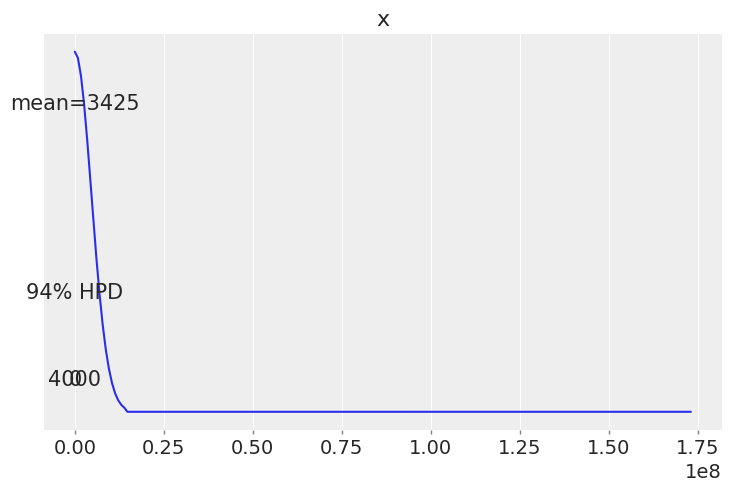

In [27]:
import arviz as az

az.style.use("arviz-darkgrid")
testDuration = np.array(dfAllTrades[dKeys[3]]['Duration'].dropna())
az.plot_posterior(testDuration);

In [31]:
dKeys = list(dfAllQuotes.keys()) #one common set of keys at the moment
dTradeKeys = list(dfAllTrades.keys())


True

In [47]:
idx=0
dfBID =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[idx]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'TimeStampS'})#.drop(QuoteColumns, inplace=True, axis=1)
dfASK =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[idx]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','time':'TimeStampS'})#.drop(QuoteColumns, inplace=True, axis=1)
#dfAllTrades[dKeys[0]].TradeTimeStamp.diff().dropna()/np.timedelta64(1, 'ms')

In [48]:
import lib.pandas.dataframe.asOfJoin

ModuleNotFoundError: No module named 'lib'

In [56]:
pd.concat([dfBID, dfASK],axis=1, join='outer')

,Unnamed: 0,bestBidSize,TimeStampS,BidSide,bestBidPrice,TimeStamp,Unnamed: 0,bestAskSize,TimeStampS,AskSide,bestAskPrice,TimeStamp
0,0.0,760.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT
1,NaN,NaN,NaN,NaN,NaN,NaT,1.0,674.0,2018-04-23 00:00:00,ASK,119.437500,2018-04-23 00:00:00
2,2.0,791.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT
3,3.0,837.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT
4,4.0,846.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT
5,5.0,850.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT
6,6.0,851.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT
7,7.0,820.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT
8,8.0,811.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT
9,9.0,765.0,2018-04-23 00:00:00,BID,119.421875,2018-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT


In [62]:
dfMergedLOB = dfBID.merge(dfASK,left_on='TimeStampS', right_on='TimeStampS')

In [64]:
dfMergedLOB.columns.values

array(['Unnamed: 0_x', 'bestBidSize', 'TimeStampS', 'BidSide',
       'bestBidPrice', 'TimeStamp_x', 'Unnamed: 0_y', 'bestAskSize',
       'AskSide', 'bestAskPrice', 'TimeStamp_y'], dtype=object)

In [66]:
dfCleanLOB=dfMergedLOB.drop(['Unnamed: 0_x', 'Unnamed: 0_y','AskSide','BidSide'], axis=1)

MemoryError: 

In [44]:
# dfLOBraw ={}
# for idx, dateKey in enumerate(commonDates):
#     dfBID =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[0]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'BidTimeStamp'})
#     dfASK =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[0]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','time':'AskTimeStamp'})
#     dfLOBraw[dKeys[idx]] =pd.concat([dfBID, dfASK],axis=1, join='outer')

In [ ]:
idx=0
dfBID =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[idx]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'BidTimeStamp'})#.drop(QuoteColumns, inplace=True, axis=1)
dfASK =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[idx]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','time':'AskTimeStamp'})#.drop(QuoteColumns, inplace=True, axis=1)
dfAllTrades[dKeys[0]].TradeTimeStamp.diff().dropna()/np.timedelta64(1, 'ms')
#dfAllQuotes[dateKeys[idx]]['Time']= dfAllQuotes[dateKeys[idx]]['time'].dt.time
    
    

In [ ]:
dfASK.columns.values
AskColumns =['level_0', 'index', 'Unnamed: 0','TimeStamp', 'AskSide']
dfASK.head(4)

In [ ]:
dfAllTrades[dKeys[0]].TradeTimeStamp.diff().dropna()/np.timedelta64(1, 'ms')

In [ ]:
type(np.random.randn(100_000)[0])

In [ ]:
columns = ['index', 'Unnamed: 0','time','AskSide']
# df.drop(columns, inplace=True, axis=1)

In [ ]:
dfBID =dfAllQuotes[dKeys[0]][dfAllQuotes[dKeys[0]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','TimeStamp':'BidTimeStamp'})
dfASK =dfAllQuotes[dKeys[0]][dfAllQuotes[dKeys[0]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','TimeStamp':'AskTimeStamp'})

In [ ]:
dfASK.head(3)

In [ ]:
columns = [ 'Unnamed: 0','TimeStamp','AskSide']
dfASK.drop(columns, inplace=True, axis=1)
dfASK.head(3)

In [ ]:
columns = [ 'Unnamed: 0','TimeStamp','BidSide']
dfBID.drop(columns, inplace=True, axis=1)
dfBID.head(3)

In [ ]:
dfLOBraw =pd.concat([dfBID, dfASK],axis=1, join='outer').ffill().dropna()
dfLOBraw.tail(125)

In [ ]:
tp_rolling=test_file['TradedPrice'].rolling(5).mean()
v= test_file['Volume'].rolling(5).mean()
df=test_file
# df.groupby(df.index).rolling(7).apply(lambda x: np.average(x.TradedPrice, weights=x.Volume))

In [ ]:
# # Groupby column with rolling mean.
# df_grouped_rolling = df.groupby(df.index)[['TradedPrice', 'Volume']].rolling(window=3, min_periods=2).min()
# df_grouped_rolling.groupby(df_grouped_rolling.index).rolling(7).apply(lambda x: np.average(x.TradedPrice, weights=x.Volume))
# # # df_grouped_rolling.head(10)
# df_grouped_rolling

In [ ]:
# idx=0
# trades_files_loc = os.path.join(data_dir,bmrg_trades[idx])
# trades_files= os.listdir(os.path.join(data_dir,bmrg_trades[idx]))
# # file_idx=1
# for file_idx,_ in enumerate(trades_files):
#     symbol='G_1_Comdty'
#     print('working on symbol:', symbol)
#     trades_df = pd.read_csv(os.path.join(trades_files_loc, trades_files[file_idx]), index_col=0)
#     print('reading this:', trades_files[file_idx])
#     trades_df=trades_df.rename(index=str, columns={"size": "Volume","value":"TradedPrice"}).drop(columns=['type'])
#     trades_df['TradedTime'] = pd.to_datetime(trades_df['time'])
#     trades_df= trades_df.drop(columns=['time'])
#     res = trades_df.groupby('TradedTime').apply(agg_on_trd_time)
#     res.reset_index(inplace=True)
#     res.loc[:, 'Duration'] = res['TradedTime']- res['TradedTime'].shift(1)
#     res['Duration'].fillna(value=0, inplace=True)
#     res.loc[:, 'Duration'] = res['Duration'].apply(lambda tt: tt.total_seconds())
#     res.loc[1:, 'ReturnTradedPrice'] = \
#         res['TradedPrice'].rolling(window=2).apply(lambda xx: np.log(xx[-1]/xx[0]))
#     res.loc[0, 'ReturnTradedPrice'] = 0.
#     target_file_name
#     target_file_name = os.path.join(os.path.join(data_dir,symbol),trades_files[file_idx])
#     print('saving here:', target_file_name)karima
#     res[['TradedTime', 'TradedPrice', 'ReturnTradedPrice', 'Volume', \
#          'Duration']].to_csv(target_file_name, index=False)
# print(res.columns.values)                       

In [ ]:
# for idx, symbol_trades in enumerate(bmrg_trades):
#     trades_files_loc = os.path.join(data_dir,bmrg_trades[idx])
#     trades_files= os.listdir(os.path.join(data_dir,bmrg_trades[idx]))
#     symbol="_".join((bmrg_trades[idx].split('_')[0],"Comdty"))
#     print('working on symbol:', symbol)
#     for file_idx,_ in enumerate(trades_files):
#         print('reading this:', trades_files[file_idx])
#         trades_df = pd.read_csv(os.path.join(trades_files_loc, trades_files[file_idx]), index_col=0)
#         trades_df=trades_df.rename(index=str, columns={"size": "Volume","value":"TradedPrice"}).drop(columns=['type'])
#         trades_df['TradedTime'] = pd.to_datetime(trades_df['time'])
#         trades_df= trades_df.drop(columns=['time'])
#         res = trades_df.groupby('TradedTime').apply(agg_on_trd_time)
#         res.reset_index(inplace=True)
#         res.loc[:, 'Duration'] = res['TradedTime']- res['TradedTime'].shift(1)
#         res['Duration'].fillna(value=0, inplace=True)
#         res.loc[:, 'Duration'] = res['Duration'].apply(lambda tt: tt.total_seconds())
#         res.loc[1:, 'ReturnTradedPrice'] = \
#             res['TradedPrice'].rolling(window=2).apply(lambda xx: np.log(xx[-1]/xx[0]))
#         res.loc[0, 'ReturnTradedPrice'] = 0
#         target_file_name = os.path.join(os.path.join(data_dir,symbol),trades_files[file_idx])
#         print('saving here:', target_file_name)
#         res[['TradedTime', 'TradedPrice', 'ReturnTradedPrice', 'Volume', \
#              'Duration']].to_csv(target_file_name, index=False)

        
    


In [ ]:
# symbol_path = find_path(data_dir, str(bmrg_symbols[0]))
# symbol_files=os.listdir(symbol_path)

# symbol=symbol_files[1].split('-')[0]
# date=symbol_files[1].split('-')[1].split('.')[0]
idx=3
trades_loc= os.path.join(data_dir,bmrg_trades[1])
list_files =os.listdir(os.path.join(data_dir,bmrg_trades[1]))
trades_file = os.path.join(trades_loc, list_files[idx])
df= pd.read_csv(trades_file,index_col=0 )
df.drop(columns=['type'])

In [ ]:
from dateutil.parser import parse
import datetime as dt
# sample = parse(df['time'].iloc[:,1])
# print(sample)
sample=parse(df['time'].iloc[12])
# # datetime.datetime(2010, 2, 15, 0, 0)
# print(dt.strftime('%d/%m/%Y'))
# # 15/02/2010
sample_time=sample.time()
sample_time.strftime('%H:%M:%S.%f')

# Crypto Data#

In [ ]:
import os
crypto=os.path.join(data_only_drive,'crypto/BTCUSD.PERP.BMEX')
os.listdir(data_only_drive)

In [ ]:
crypto_path=os.path.join(data_only_drive,'crypto')
trades_crypto_path = os.path.join(crypto_path,'trades')
perp_trades_loc= os.path.join(trades_crypto_path,'BTCUSD.PERP.BMEX')
perp_trades_list=os.listdir(perp_trades_loc)

In [ ]:
LOB = os.path.join(crypto_path,'LOB')
lob_files= os.listdir(os.path.join(LOB,os.listdir(LOB)[0]))


In [ ]:
sample_file = pd.read_csv(os.path.join(perp_trades_loc, perp_trades_list[0]), index_col=0)

In [ ]:
os.path.join(perp_trades_loc, perp_trades_list[0])

In [ ]:
sample_file.reset_index(inplace=True)

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
sample_file=sample_file.drop(columns=['index'])

In [ ]:
sample_file.columns.values

In [ ]:
crypto_df= pd.to_datetime(sample_file['received_at'])

In [ ]:
crypto_df['TradedPrice']= sample_file['price']


In [ ]:
sample_file =sample_file.rename(index=str, columns={"received_at":"TradedTime","side":"Side"})

In [ ]:
sample_file['TradedTime']=pd.to_datetime(sample_file['TradedTime'])

In [ ]:
sample_file =sample_file.rename(index=str, columns={"price":"TradedPrice","size":"Volume"})

In [ ]:
def get_time(date_time):
    timestamp= date_time.strftime('%H:%M:%S.%f')
    return timestamp

In [ ]:
sample_file['TradedTime']=sample_file['TradedTime'].apply(get_time)

res = sample_file.groupby('TradedTime').apply(agg_on_trd_time)
res.reset_index(inplace=True)
res.loc[:, 'Duration'] = res['TradedTime']- res['TradedTime'].shift(1)
res['Duration'].fillna(value=0, inplace=True)
res.loc[:, 'Duration'] = res['Duration'].apply(lambda tt: tt.total_seconds())
res.loc[1:, 'ReturnTradedPrice'] = \
res['TradedPrice'].rolling(window=2).apply(lambda xx: np.log(xx[-1]/xx[0]))
res.loc[0, 'ReturnTradedPrice'] = 0

In [ ]:
data_dir = os.getenv('FINANCE_DATA') #main directory
data_only_drive= '/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2'
bmrg_symbols=[s for s in os.listdir(data_dir) if s.endswith('20181028') or s.endswith('20181027')]


bmrg_symbols_destinations=[s for s in os.listdir(data_dir) if s.endswith('trades') or s.endswith('quotes')]
bmrg_tickers=[bmrg_symbols_destinations[idx].split('_t')[0] or \
              bmrg_symbols_destinations[idx].split('_q')[0] for idx,_ in enumerate(bmrg_symbols_destinations)]
ftse_symbols= [s for s in os.listdir(data_dir) if s.endswith('.L')]
features_models_dd= os.path.join(data_dir, 'features_models')
labels = os.path.join(features_models_dd, 'labels')
model_features= os.path.join(features_models_dd, 'features')
features_models_dOd= os.path.join(data_only_drive, 'features_models')

In [ ]:
data_dir
ftse_symbols= [s for s in os.listdir(data_dir) if s.endswith('.L')]
test=os.listdir(os.path.join(data_dir, ftse_symbols[1]))
len(test)

In [ ]:

for idx,_ in enumerate(ftse_symbols):
    symbol=ftse_symbols[idx] # set symbol
    features_models_path = '/media/ak/WorkDrive/Data/features_models/models/'
    features_only_path = '/media/ak/WorkDrive/Data/features_models/features/'
    symbol_raw_data_path = os.listdir(os.path.join(data_dir, symbol))
    symbol_hmm_model_path = os.listdir(os.path.join(features_models_path, symbol,'HMM'))
    symbol_labels_path= os.listdir(os.path.join(labels, symbol,'NON_DIRECTIONAL')) # set labels path for the symbol
    market_features_path = os.listdir(os.path.join(data_only_drive,'Data','features_models',symbol,'MARKET_BASED'))
    symbol_model_features = os.listdir(os.path.join(features_only_path, symbol, 'MODEL_BASED'))
#     print('symbol: ', symbol)
# #     print('number of days: ', len(symbol_raw_data_path))
# #     print('number of hmm models: ', len(symbol_hmm_model_path))
# #     print("number of date files in labels:",len(symbol_labels_path))
#     print("mearket features:", len(market_features_path))
#     print("common elements between market features and labels:",len(list(common_member(market_features_path, \
#                                                                                        symbol_labels_path))))
# #     if len(symbol_raw_data_path)!= len(symbol_labels_path):
# #         print('check symbol:',symbol)
# #         problem_list.append(symbol)


In [ ]:
##test case##
symbol='AAL.L' # set symbol
features_models_path = '/media/ak/WorkDrive/Data/features_models/models/'
symbol_raw_data_path = os.path.join(data_dir, symbol)
symbol_hmm_model_path = os.path.join(features_models_path, symbol,'HMM')
symbol_labels_path= os.path.join(labels, symbol,'NON_DIRECTIONAL') # set labels path for the symbol
market_features_path = os.path.join(data_only_drive,'Data','features_models',symbol,'MARKET_BASED')
print('symbol: ', symbol)
print(symbol_raw_data_path)
print(symbol_hmm_model_path)
print(symbol_labels_path)
print(market_features_path)


In [ ]:
symbol_features = os.listdir(os.path.join(features_only_path, symbol, 'MODEL_BASED')) #this is a list of folders, indexed by date
labels_dates= [symbol_labels_path[idx].split(".")[0] for idx, _ in enumerate(symbol_labels_path)]
date=labels_dates[1]
# for _, date in enumerate(labels_dates):
date_symbol_features = os.path.join(features_only_path, symbol, 'MODEL_BASED', date)
date_feature_list= os.listdir(date_symbol_features)
for idx, _ in enumerate(date_feature_list):
    open_pickle_file(path=date_symbol_features, pickle_file=date_feature_list[idx])


In [ ]:
date
date_symbol_features = os.path.join(features_only_path, symbol, 'MODEL_BASED', date)
date_symbol_features
date_feature_list= os.listdir(date_symbol_features)
print date_feature_list
for idx, _ in enumerate(date_feature_list):
     open_pickle_file(path=date_symbol_features, pickle_file=date_feature_list[idx])[1]

In [ ]:
# for idx, date  in enumerate(symbol_model_features):
#     print os.listdir(os.path.join(features_only_path, symbol, 'MODEL_BASED', date))
date_feature_list= os.listdir(date_symbol_features)
for idx, _ in enumerate(date_feature_list):
    print date_feature_list[idx]

In [ ]:
duration=pd.read_csv(file_location,index_col=0)['Duration']
non_directional_labels = pd.read_csv(file_location,index_col=0)['label_PrMov__window_25__thres_arbitrary__10.0'] #this is a problem
df = pd.read_csv(file_location,index_col=0)
features_dates_dir= os.listdir(symbol_features_path)#
# path for a specific hmm model date --- out of sample pickle files
pickle_features_path= os.path.join(symbol_features_path, features_dates_dir[1])

In [ ]:
os.listdir(pickle_features_path)

In [ ]:
# 'III.L_3_states_features_date:_20171024_now:_20181226_
compute_date= '20181226'
date= features_dates_dir[5]
features_pickle_file = "_".join((symbol,'3_states_features_date:',features_dates_dir[5],'now:',compute_date,'.pickle'))

In [ ]:
model_features =open_pickle_file(pickle_features_path,features_pickle_file) #tuple for all the HMM- model features

In [ ]:
market_features_path = os.path.join(data_only_drive,'Data','features_models',symbol,'MARKET_BASED')

In [ ]:
market_features= os.path.join(market_features_path, date)

In [ ]:
if os.path.isfile(market_features):
    pd.read_csv(market_features)
else:
    pass

In [ ]:
market_features_dates= [os.listdir(market_features_path)[idx].split(".")[0] for idx, _ in enumerate(market_features_path)]

In [ ]:
def common_member(a, b): 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

In [ ]:
common_elements=list(common_member(features_dates_dir, market_features_dates))

In [ ]:
len(common_elements)

In [ ]:
len(features_dates_dir)

In [ ]:
len(market_features_dates)